<a href="https://colab.research.google.com/github/EddyGiusepe/Segmentacao_de_clientes_KMeans/blob/main/Segmenta%C3%A7%C3%A3o_de_clientes_shopping_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h2 align='center'>**Segmentação de clientes de shopping**</h2>


## **Cientista de Dados:** Eddy Giusepe Chirinos Isidro


Os Dados usando estão [aqui](https://www.kaggle.com/glushko/mall-customer-segmentation?select=Mall_Customers.csv)

Também pode ver [este exemplo](https://www.kaggle.com/kushal1996/customer-segmentation-k-means-analysis)

![alt text](https://storage.googleapis.com/kaggle-datasets-images/42674/74935/572dbd518d7eceb1d680c1a36fde9a40/dataset-cover.jpg)

## 1. <font color="red">Importamos as nossas bibliotecas</font>

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly as py


from sklearn import set_config

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


#clustering 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

## 2. <font color="red">Importando e explorando nossos Dados</font>

In [3]:
customer_df = pd.read_csv('/content/drive/MyDrive/1_Kaggle_TensorFlow_linksJORGE_etc/Kaggle/Segmentação_de_clientes_de_shopping/Mall_Customers.csv')

In [4]:
customer_df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
# Eliminamos a coluna ""CustomerID
customer_df = customer_df.drop('CustomerID', axis=1)

In [6]:
customer_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [7]:
customer_df = customer_df.rename(index=str,
                                 columns={'Annual Income (k$)': 'Income',
                                          'Spending Score (1-100)':'Spending Score'})

In [8]:
customer_df.head()

,Gender,Age,Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


O conjunto de dados contém apenas 200 clientes com 4 características. Todas as características são preenchidas (sem valores ausentes).

In [9]:
customer_df.shape

(200, 4)

In [10]:
customer_df.dtypes

Gender            object
Age                int64
Income             int64
Spending Score     int64
dtype: object

In [11]:
customer_df.describe()

,Age,Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [12]:
customer_df.isnull().sum()

Gender            0
Age               0
Income            0
Spending Score    0
dtype: int64

In [13]:
# Nosso DataFrame fica assim:

customer_df.sample(5)

,Gender,Age,Income,Spending Score
192,Male,33,113,8
49,Female,31,40,42
176,Male,58,88,15
117,Female,49,65,59
111,Female,19,63,54


## 3. <font color="red">Visualização de nossos Dados</font>

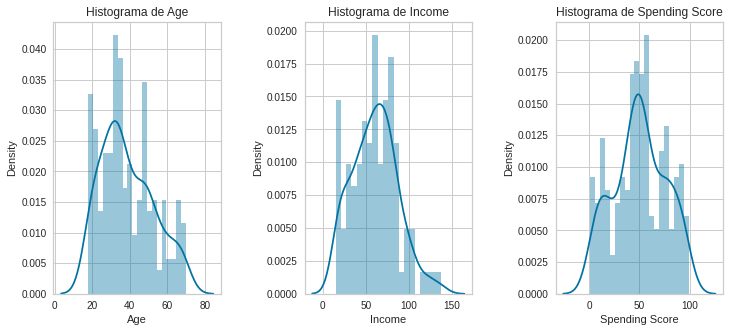

In [14]:
plt.figure(figsize = (12 , 5))
n = 0 
for x in ['Age' , 'Income' , 'Spending Score']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(customer_df[x] , bins = 20)
    plt.title('Histograma de {}'.format(x))
plt.show()

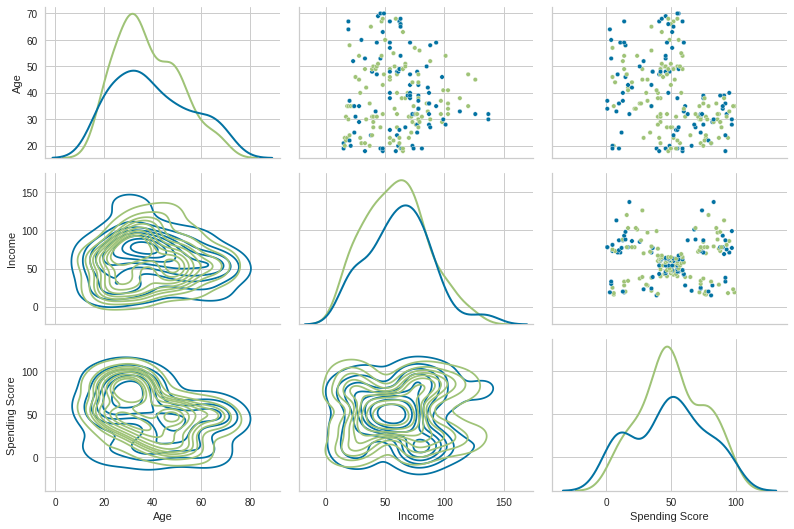

In [15]:
grid = sns.PairGrid(customer_df, hue='Gender', diag_sharey=False, aspect=1.5)

grid.map_upper(sns.scatterplot, s=20)
grid.map_lower(sns.kdeplot)
grid.map_diag(sns.kdeplot, lw=2)
plt.show()

#ou
#g = sns.PairGrid(customer_df)
#g.map_diag(plt.hist)
#g.map_upper(plt.scatter)
#g.map_lower(sns.kdeplot)

# Seguidamente pode comparar com o "pairplot"
# sns.pairplot(customer_df, hue='Gender')

**Intuições (Insights)**

* As características de Idade (``Age``), Renda (``Income``) e Pontuação de Gastos (``Spending Score``) são **distribuições multimodais**, cada uma com dois ou três saltos;

* O gráfico de Renda Anual (``Annual Income``) e Pontuação de Gastos parece ser formado com cinco regiões densas: $4$ regiões estão nas laterais e uma está no centro.

**Perfil do cliente**:

Gênero

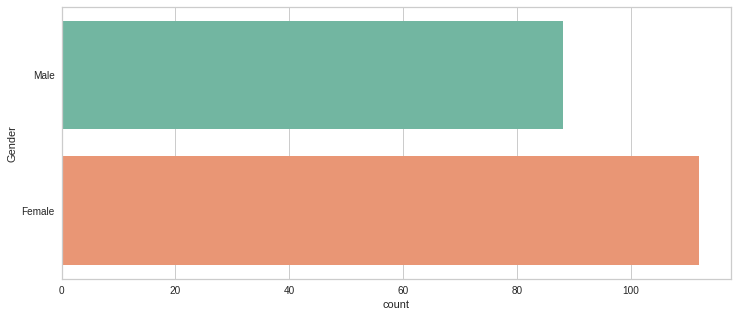

In [16]:
plt.figure(figsize=(12, 5))
sns.countplot(y = 'Gender', data = customer_df, palette = "Set2")
plt.show()


In [17]:

fig = px.pie(
    data_frame = customer_df,
    names = 'Gender',
    title = 'Gênero de clientes',
    hole = 0.1,
    color_discrete_sequence = px.colors.qualitative.Set1,
    width=400, 
    height=400
)

fig.show()


**Insights**:

os clientes do sexo feminino são 6% a mais do que os do sexo masculino. Distribuição praticamente uniforme

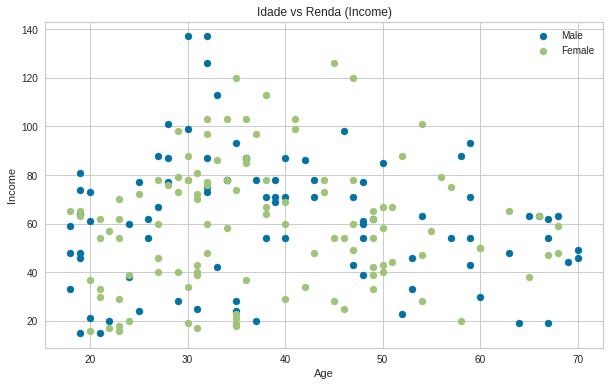

In [18]:
plt.figure(figsize = (10 , 6))

for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Income' , data = customer_df[customer_df['Gender'] == gender] ,
                s = 50 , alpha = 1 , label = gender)
plt.xlabel('Age') 
plt.ylabel('Income') 
plt.title('Idade vs Renda (Income)')
plt.legend()
plt.show()

In [19]:
customer_df[['Age', 'Income']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,38.85,13.969007,18.0,28.75,36.0,49.0,70.0
Income,200.0,60.56,26.264721,15.0,41.50,61.5,78.0,137.0


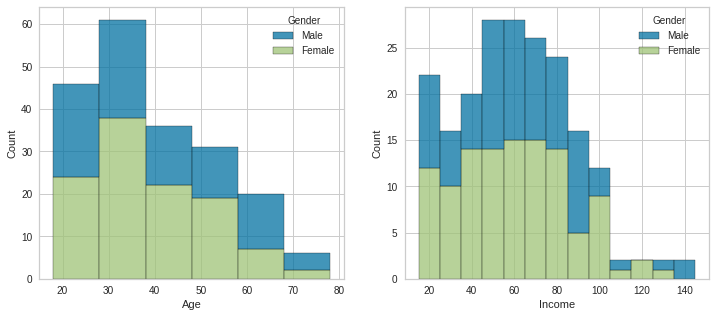

In [20]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(data=customer_df, x='Age', hue='Gender', binwidth=10, multiple='stack',
             ax=ax0)

sns.histplot(data=customer_df, x='Income', hue='Gender', binwidth=10, multiple='stack',
             ax=ax1)

plt.show()

Insights:

* $20-30$, $30-40$ são as faixas etárias mais comuns entre os clientes;

* A maior faixa etária de clientes são os clientes de $30$ anos (principalmente mulheres);

* A maioria dos clientes ganha entre $\$50\,000$ e $\$80\,000$ anualmente;

* Grande parte dos clientes ganha apenas $\$20\,000$ anualmente.

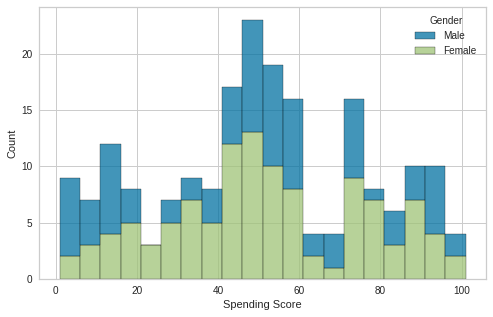

In [21]:
plt.figure(figsize=(8, 5))

sns.histplot(data = customer_df, x='Spending Score',
             hue='Gender', binwidth=5, multiple='stack')
plt.show()

**Insights**

As pontuações de gastos têm alguns modos: 
* entre $0$ e $20$ (os homens dominam);

* entre $25$ e $40$ (mulheres dominam);

* entre $45$ e $60$ (mulheres dominam);

* entre $65$ e $70$ (homens dominam)

* entre $70$ e $100$ (mulheres dominam)

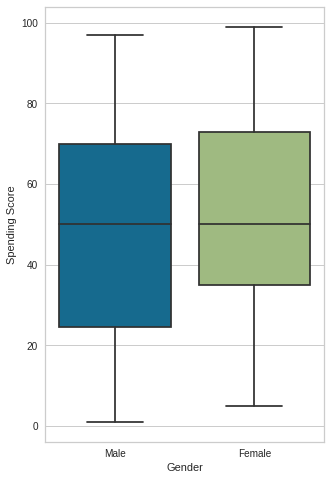

In [22]:
# Spending score

plt.figure(figsize=(5, 8))
sns.boxplot(data=customer_df, x='Gender', y='Spending Score')
plt.show()


**Insights**:

* As mulheres tendem a gastar mais, como podemos ver no limite da barra inferior;

* Em média, as mulheres gastam um pouco mais do que os homens.

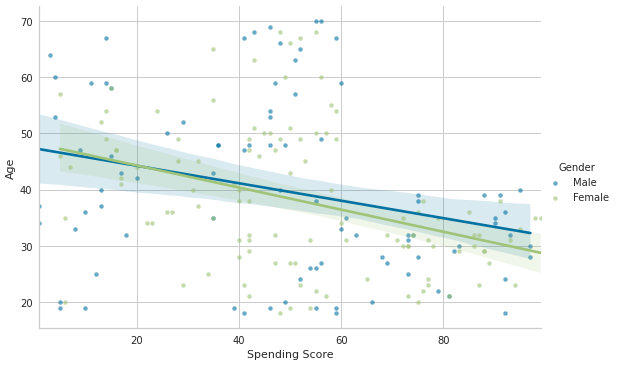

In [23]:
sns.lmplot(
    data = customer_df,
    x='Spending Score', 
    y='Age', 
    hue='Gender',
    aspect=1.5,
    scatter_kws={'s': 20, 'alpha': 0.6}
)
sns.set_style('darkgrid')

**Insights**:

* Existe uma dependência linear entre ``Pontuação de Gastos`` e ``Idade``. Os clientes mais jovens tendem a ter uma pontuação de gastos mais alta e a pontuação de gastos diminui com o aumento da idade.



Apresentar grupos de gastos pode ajudar a revelar mais Insights. Então, vamos apresentar três grupos de gastos:

In [24]:
def impute_spending_group(spending_score):
    if spending_score <= 35:
        return 'low'
    if spending_score > 35 and spending_score <= 65:
        return 'medium'
    if spending_score > 65:
        return 'high'

In [25]:

customer_df['SpendingGroup'] = customer_df['Spending Score'].apply(impute_spending_group)



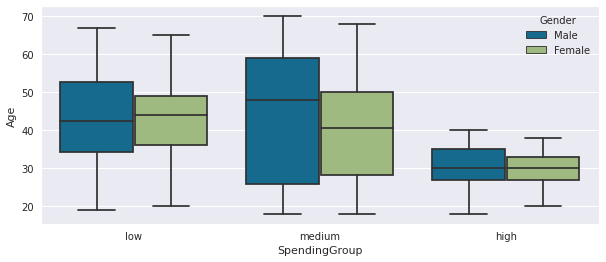

In [26]:
plt.figure(figsize=(10, 4))
sns.boxplot(data = customer_df, x='SpendingGroup', y='Age',
            hue='Gender', order=['low', 'medium', 'high'])
plt.show()

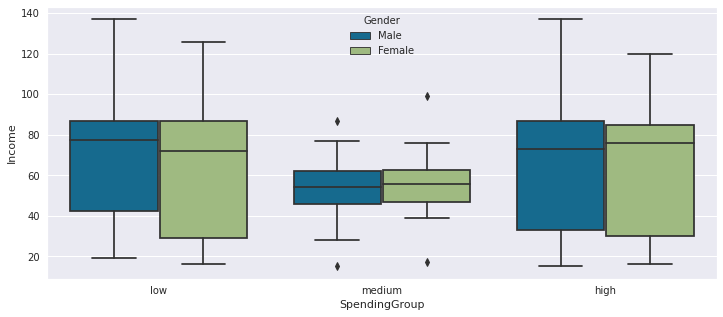

In [27]:
plt.figure(figsize=(12, 5))
sns.boxplot(data = customer_df, x='SpendingGroup', y='Income',
            hue='Gender', order=['low', 'medium', 'high'])
plt.show()

**Insights**:

* No gráfico ``Grupo de gastos`` (SpendingGroup) - ``Idade`` (Age), podemos ver que a menor variação está no grupo de gastos altos. Seus membros estão na faixa etária de $20$ a $40$ anos. Os grupos de gastos baixos e médios parecem cobrir aproximadamente toda a faixa etária;

* No gráfico ``Grupo de gastos`` - ``Renda Anual`` (Annual Income), podemos ver que os clientes do centro da distribuição de renda anual ($\$40\,000$- $\$60\,000$) pertencem ao grupo de gastos médios.


Vamos dar uma olhada mais aprofundada nas relações de ``renda anual`` e ``pontuação de gastos``:




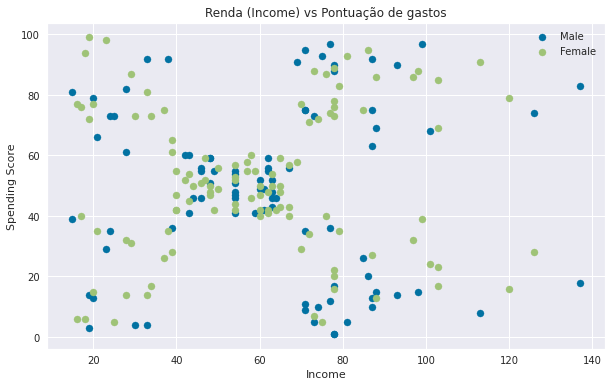

In [28]:
#plt.figure(figsize=(10, 5))
#sns.scatterplot(data = customer_df, x='Spending Score', y='Income', hue='Gender')

plt.figure(figsize = (10 , 6))

for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Income' , y = 'Spending Score' , data = customer_df[customer_df['Gender'] == gender],
                s = 50 , alpha = 1 , label = gender)
plt.xlabel('Income') 
plt.ylabel('Spending Score') 
plt.title('Renda (Income) vs Pontuação de gastos')
plt.legend()
plt.show()

Insights:

Cinco clusters visualmente reconhecíveis parecem representar clientes que:

* têm alta renda e baixa pontuação de gastos;

* baixa renda e baixa pontuação de gastos;

* alta renda e baixa pontuação de gastos;

* alta renda e alta pontuação de gastos;

* cluster médio denso com renda média e pontuação média de gastos.

## 4. <font color="red">Clustering usando KMeans</font>



### A. <font color="orange">Segmentação por Idade e Pontuação de Gastos</font>



**K-Means**


Um padrão razoavelmente bom para tarefas de cluster é o algoritmo ``K-means``.

Funciona melhor quando há distâncias semelhantes dos centróides aos membros do cluster. Isso implica que os clusters devem ter forma circular.

À primeira vista, isso não parece ser o caso, portanto, podemos esperar uma quantidade de clientes com cluster incorreto perto dos limites do cluster.

Para usar o modelo ``K-means``, precisamos saber quantos clusters estão no conjunto de dados. Embora visualmente (ver o gráfico acima) esteja claro que existem cinco grupos, não nos contentaremos apenas com isso e usaremos o **método do cotovelo** e **o diagrama da silhueta** como pistas adicionais.


O método do ``Elbow`` (cotovelo) sugere o uso de $6$ grupos em vez de $5$, o que presumimos no início. Isso pode estar correto porque olhamos para a simplificação de duas dimensões do conjunto de dados (Spending Score-Income plot), embora tenhamos $4$ dimensões no total. Em um espaço mais dimensional, pode haver grupos (clusters) realmente mais distintos.

Agora vamos plotar diagramas de silhueta. Vamos descobrir $[5, 6, 8]$ uma gama de números de cluster possíveis para verificar se $6$ é um bom número de cluster para seguir.


Os diagramas de silhueta incorporam mais informações do que o gráfico do ``cotovelo``. Cada "lâmina" no diagrama representa um cluster separado. A altura das lâminas representa o número de amostras dentro do cluster e a largura representa a força das conexões entre os clusters.

Nosso objetivo será encontrar aglomerados quase do mesmo tamanho (as alturas são quase as mesmas) que estão fortemente conectados (a largura está próxima ao lado direito do gráfico).


Agora, dando uma olhada nos gráficos que fizemos para $5$, $6$, $8$ clusters, podemos ver que eles são quase os mesmos em termos de conectividade e tamanho entre clusters. No diagrama de 8 grupos, há mais um cluster $7$ fortemente conectado que está ausente nas outras parcelas. Vamos considerar isso como um sinal de qualidade de cluster ligeiramente melhor. No pior dos casos, obteríamos clusters um pouco granulares que seríamos capazes de fundir de acordo com as necessidades de marketing.

Durante os experimentos, tentei ir além de $8$ clusters, mas diagramas de cluster superiores não parecem ideais. Alguns clusters apresentaram pontuação de silhueta negativa, o que é sinal de agrupamento incorreto da amostra. Além disso, determinado conjunto de dados contém apenas $4$ características, o que limita o possível agrupamento. Por exemplo, quando o número de clusters é maior que $10$, o diagrama de silhueta começa a mostrar clusters vazios.

\\

No espaço ``Spending Score`` - ``Income``, $8$ clusters têm a seguinte aparência:


Evidentemente, o espaço $2d$ não é suficiente para mostrar à distância todos os $8$ clusters. Iremos explorá-los no espaço dimensional superior mais adiante neste caderno.

**Cluster Analysis**


Vamos reproduzir o agrupamento ``K-means`` com $8$ clusters para explorar mais a fundo:

O espaço $2d$ nos limita e precisamos ir para o espaço $3D$ para entender nossos clusters:

In [29]:
'''Age and spending Score'''

X1 = customer_df[['Age' , 'Spending Score']].iloc[: , :].values
inertia = []

for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)
    

Seleção de N clusters com base na inércia (distância quadrada entre centróides e pontos de dados, deve ser menor)

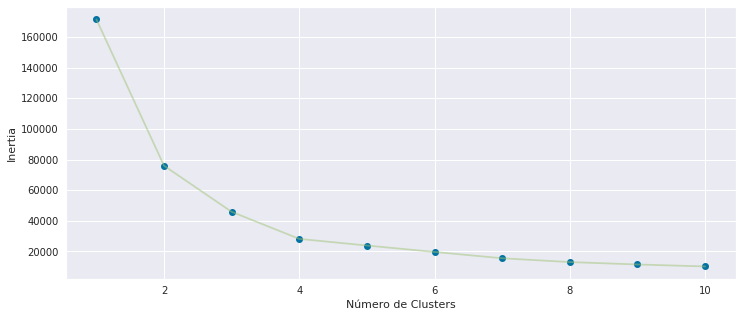

In [30]:
plt.figure(1 , figsize = (12 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

In [31]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [32]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()]) 


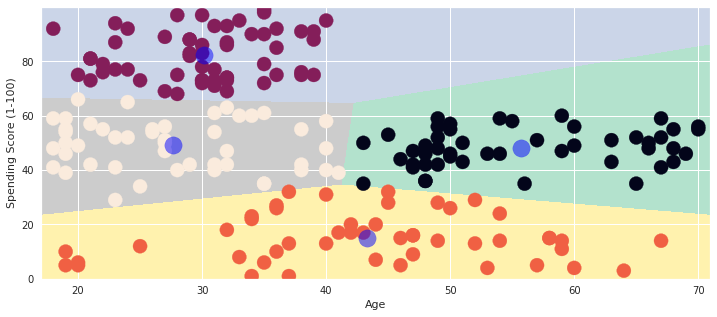

In [33]:
plt.figure(1 , figsize = (12 , 5) )
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Age' ,y = 'Spending Score' , data = customer_df , c = labels1 , 
            s = 200 )
plt.scatter(x = centroids1[: , 0] , y =  centroids1[: , 1] , s = 300 , c = 'blue' , alpha = 0.5)
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)')
plt.show()

### B. <font color="orange">Segmentação usando renda anual e pontuação de gastos</font>

In [34]:
'''Annual Income and spending Score'''

X2 = customer_df[['Income' , 'Spending Score']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') 
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

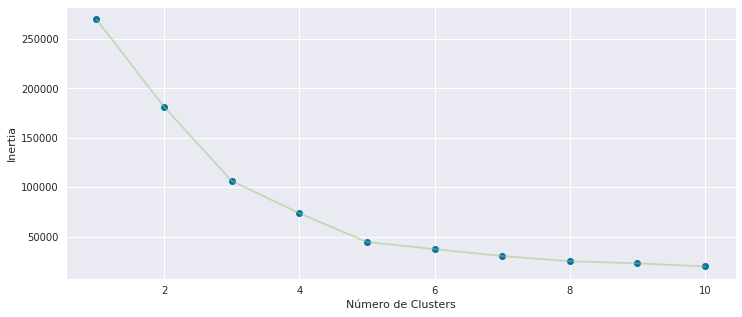

In [35]:
plt.figure(figsize = (12 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

In [36]:
algorithm = (KMeans(n_clusters = 5 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [37]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

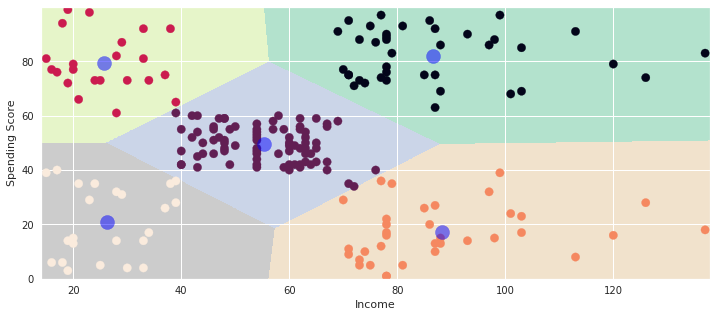

In [38]:
plt.figure(1 , figsize = (12 , 5) )
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2 , interpolation='nearest', 
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x = 'Income' ,y = 'Spending Score' , data = customer_df , c = labels2 , 
            s = 70 )
plt.scatter(x = centroids2[: , 0] , y =  centroids2[: , 1] , s = 200 , c = 'blue' , alpha = 0.5)
plt.ylabel('Spending Score')
plt.xlabel('Income')
plt.show()

### C. <font color="orange">Segmentação por Idade, Receita Anual e Pontuação de Gastos</font>


In [39]:
X3 = customer_df[['Age' , 'Income' ,'Spending Score']].iloc[: , :].values
inertia = []

for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)
    

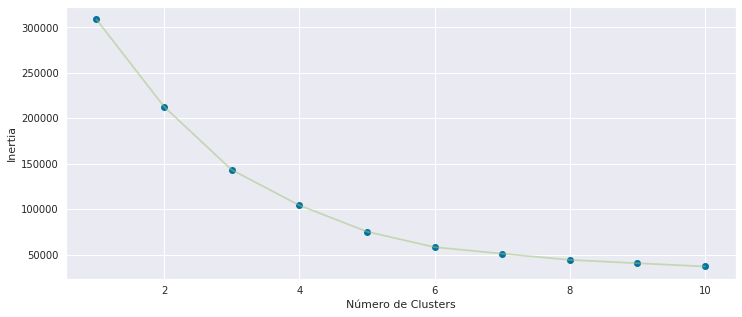

In [40]:

plt.figure(1, figsize = (12 ,5))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()


In [41]:
algorithm = (KMeans(n_clusters = 6 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_

In [42]:
customer_df['label3'] =  labels3
trace1 = go.Scatter3d(
    x= customer_df['Age'],
    y= customer_df['Spending Score'],
    z= customer_df['Income'],
    mode='markers',
     marker=dict(
        color = customer_df['label3'], 
        size= 5,
        line=dict(
            color= customer_df['label3'],
            width= 12
        ),
        opacity=0.5
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Age'),
            yaxis = dict(title  = 'Spending Score'),
            zaxis = dict(title  = 'Annual Income')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)